In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
import seaborn as sns
from matplotlib import pyplot as plt

# Gene only (no disease)

## Processing data

In [117]:
genes = pd.read_pickle('./OT/Final/targets.pkl').rename({'gene_id':'targetId'},axis=1)
genes = genes.loc[~genes['gene'].str.contains('ENSG')]
chembl = pd.read_pickle('./OT/Raw/chembl.pkl').merge(genes)
chembl = chembl[['gene','clinicalPhase','clinicalStatus','drugId','studyId','studyStartDate','studyStopReason',
                 'studyStopReasonCategories','diseaseId','variantEffect']]
chembl = chembl.set_axis(['gene','phase','status','chembl_id','study_id','start_date','stop_reason',
                          'stop_category','disease','ot_doe'],axis=1)
dm = pd.read_pickle('./Drugs/targets.pkl').merge(pd.read_csv('./Drugs/DOE IDs/chembl_to_doeid.csv'))
dm = dm[['chembl_id','gene','moa']].drop_duplicates()
chembl = chembl.merge(dm, how='left')

chembl['active'] = chembl['status'].map({'Completed':0,'Terminated':0,'Recruiting':1,'Unknown status':0,
                             'Active, not recruiting':1,'Withdrawn':0,'Not yet recruiting':1,
                             'Suspended':0,'Enrolling by invitation':1,'None':0})
chembl['start_date'] = pd.to_datetime(chembl['start_date'])
chembl['active'] = chembl['active'].fillna(0)


In [118]:
ps = chembl.groupby(['gene'])[['phase','active']].max().reset_index()
ps = ps.rename({'phase':'max_phase'},axis=1)
ps = ps.merge(chembl.groupby(['gene','phase'])['start_date'].min().reset_index().rename({'phase':'max_phase'},axis=1), how='left')

ps.loc[ps['max_phase'] >= 1, 'p_1'] = 1
ps.loc[(ps['max_phase'] == 0.5) & (ps['active'] == 0), 'p_1'] = 0
ps.loc[ps['max_phase'] >= 2, '1_2'] = 1
ps.loc[(ps['max_phase'] == 1) & (ps['active'] == 0), '1_2'] = 0
ps.loc[ps['max_phase'] >= 3, '2_3'] = 1
ps.loc[(ps['max_phase'] == 2) & (ps['active'] == 0), '2_3'] = 0
ps.loc[ps['max_phase'] >= 4, '3_a'] = 1
ps.loc[(ps['max_phase'] == 3) & (ps['active'] == 0), '3_a'] = 0
ps.loc[ps['max_phase'] >= 4, '1_a'] = 1
ps.loc[(ps['max_phase'].isin([1,2,3])) & (ps['active'] == 0), '1_a'] = 0
ps = ps.groupby('gene')[['max_phase','p_1','1_2','2_3','3_a','1_a']].max().reset_index()

mk = pd.read_excel('./Other/minikel_drugs.xlsx')
mk['combined_max_phase'] = mk['combined_max_phase'].map({'Preclinical':0.5,'Phase I':1,'Phase II':2,'Phase III':3,'Launched':4})
mk['active'] = 0
mk.loc[mk['active_max_phase'].notna(), 'active'] = 1
mk.loc[mk['combined_max_phase'] == 4, '1_a'] = 1
mk.loc[(mk['combined_max_phase'].isin([1,2,3])) & (mk['active'] == 0), '1_a'] = 0
mk = mk[['target','combined_max_phase','active','succ_p_1','succ_1_2','succ_2_3','succ_3_a','1_a']]
mk = mk.set_axis(['gene','max_phase','active','p_1','1_2','2_3','3_a','1_a'],axis=1)

ps = pd.concat([ps,mk]).groupby('gene')[['max_phase','p_1','1_2','2_3','3_a','1_a']].max().reset_index()
ps.to_pickle('./Trials/gene_success.pkl')


In [107]:
chembl['moa'] = chembl['moa'].map({'Negative modulator':'Negative',
                                   'Positive modulator':'Positive',
                                   'Other':'Other'})
chembl = chembl.dropna(subset='moa')
chembl['gene_moa'] = chembl['gene'] + '_' + chembl['moa']

ps = chembl.groupby(['gene_moa'])[['phase','active']].max().reset_index()
ps = ps.rename({'phase':'max_phase'},axis=1)
ps = ps.merge(chembl.groupby(['gene_moa','phase'])['start_date'].min().reset_index().rename({'phase':'max_phase'},axis=1), how='left')

ps.loc[ps['max_phase'] >= 1, 'p_1'] = 1
ps.loc[(ps['max_phase'] == 0.5) & (ps['active'] == 0), 'p_1'] = 0
ps.loc[ps['max_phase'] >= 2, '1_2'] = 1
ps.loc[(ps['max_phase'] == 1) & (ps['active'] == 0), '1_2'] = 0
ps.loc[ps['max_phase'] >= 3, '2_3'] = 1
ps.loc[(ps['max_phase'] == 2) & (ps['active'] == 0), '2_3'] = 0
ps.loc[ps['max_phase'] >= 4, '3_a'] = 1
ps.loc[(ps['max_phase'] == 3) & (ps['active'] == 0), '3_a'] = 0
ps.loc[ps['max_phase'] >= 4, '1_a'] = 1
ps.loc[(ps['max_phase'].isin([1,2,3])) & (ps['active'] == 0), '1_a'] = 0
ps = ps.groupby('gene_moa')[['max_phase','p_1','1_2','2_3','3_a','1_a']].max().reset_index()

ps['gene'] = ps['gene_moa'].str.split('_').str[0]
ps['moa'] = ps['gene_moa'].str.split('_').str[1]
ps.to_pickle('./Trials/gene_moa_success.pkl')


## No DOE

In [120]:
ps = pd.read_pickle('./Trials/gene_success.pkl')
data=pd.read_csv(f'./Training/Predictions/druggability_all_holdout_predictions.csv').rename({'ID':'gene'},axis=1)
dai = pd.read_csv('./Other/drugnomeai.csv').rename({'Gene Name':'gene','Tclin & Tchem':'drugnomeai'},axis=1)[['gene','drugnomeai']]
ps=data.merge(ps, how='left').merge(dai, how='left')

results=[]
for res in['p_1','1_2','2_3','3_a','1_a']:
    for predictor in['pred_druggable','drugnomeai']:
        temp=ps.dropna(subset=[res,predictor])
        auroc_boot=[];auprc_boot=[]
        for _ in range(500):
            idx=np.random.choice(temp.index,len(temp),replace=True)
            samp=temp.loc[idx]
            auroc_boot.append(roc_auc_score(samp[res],samp[predictor]))
            auprc_boot.append(average_precision_score(samp[res],samp[predictor]))
        results.append({
            'predictor': predictor,
            'result': res,
            'proportion': ps[res].dropna().mean(),
            'success': ps[res].sum(),
            'count': len(ps[res].dropna()),
            'auroc_mean': np.mean(auroc_boot),
            'auroc_2.5': np.percentile(auroc_boot,2.5),
            'auroc_97.5': np.percentile(auroc_boot,97.5),
            'auprc_mean': np.mean(auprc_boot),
            'auprc_2.5': np.percentile(auprc_boot,2.5),
            'auprc_97.5': np.percentile(auprc_boot,97.5)
        })
results = pd.DataFrame(results)
results.to_csv('./Trials/overall_druggability.csv', index=False)


In [125]:
res = pd.read_csv('./Trials/overall_druggability.csv')
res['result'] = res['result'].map({'p_1':'Preclinical to phase I',
                                   '1_2':'Phase I to II',
                                   '2_3':'Phase II to III',
                                   '3_a':'Phase III to IV',
                                   '1_a':'Phase I to IV'})
res['result'] = res['result'] + '\n(' + res['success'].astype(int).astype(str) + '/' + res['count'].astype(int).astype(str) + ')'
res['result'] = pd.Categorical(res['result'], ['Preclinical to phase I\n(2173/2783)',
                                               'Phase I to II\n(1891/2045)', 
                                               'Phase II to III\n(1316/1684)',
                                               'Phase III to IV\n(1003/1142)',
                                               'Phase I to IV\n(1003/1803)'])
res['predictor'] = res['predictor'].map({'pred_druggable':'All features',
                                         'drugnomeai':'DrugnomeAI'})
res = res.sort_values(['predictor','result'])


In [126]:
percinc = pd.pivot_table(res, index='result', columns='predictor', values='auroc_mean').reset_index()
percinc['percent'] = 100*(percinc['All features']-percinc['DrugnomeAI'])/(percinc['DrugnomeAI'])
percinc

/tmp/ipykernel_3900057/3436422218.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  percinc = pd.pivot_table(res, index='result', columns='predictor', values='auroc_mean').reset_index()


predictor,result,All features,DrugnomeAI,percent
0,Preclinical to phase I\n(2173/2783),0.726146,0.709073,2.407833
1,Phase I to II\n(1891/2045),0.649251,0.633754,2.445147
2,Phase II to III\n(1316/1684),0.642056,0.601008,6.829809
3,Phase III to IV\n(1003/1142),0.622172,0.602845,3.205961
4,Phase I to IV\n(1003/1803),0.662446,0.630623,5.046326


Text(0, 0.5, 'AUROC')

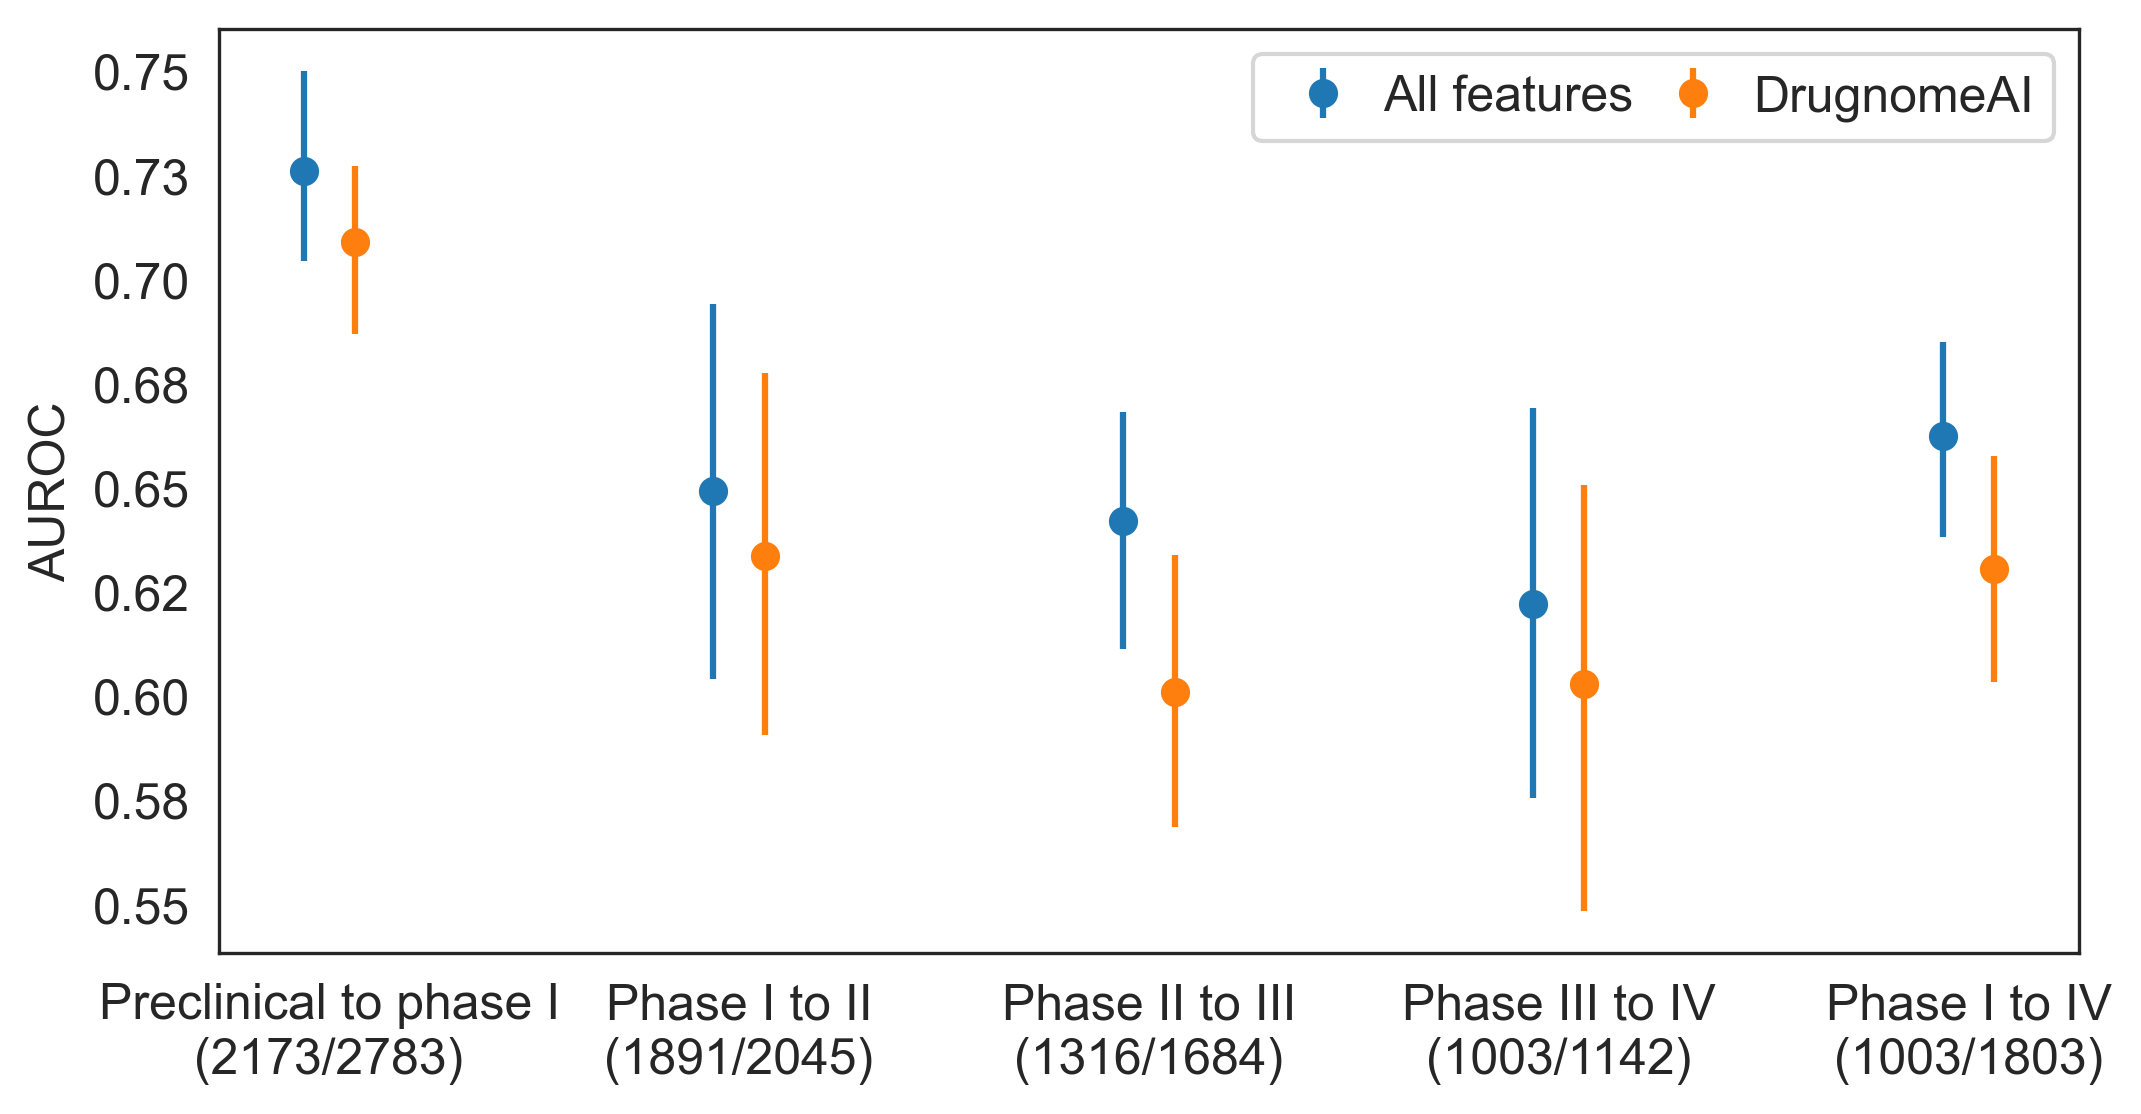

In [127]:
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['predictor'].unique()
offset = 0.125  # Offset for dodging
x_positions = range(len(res['result'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['predictor'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['auroc_mean'], 
                yerr=[subset['auroc_mean'] - subset['auroc_2.5'], subset['auroc_97.5'] - subset['auroc_mean']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['result'].unique())))
ax.set_xticklabels(res['result'].unique())
ax.legend(title='', ncols=2, loc='upper right', columnspacing=0.2, handletextpad=0.2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xlabel('')
plt.ylabel('AUROC')


In [59]:
ps = pd.read_pickle('./Trials/gene_success.pkl')
data = pd.read_csv('./Training/Predictions/druggability_all_holdout_predictions.csv').rename({'ID': 'gene'}, axis=1)
data['pred_druggable_pct'] = data['pred_druggable'].rank(pct=True)
dai = pd.read_csv('./Other/drugnomeai.csv').rename({'Gene Name': 'gene', 'Tclin & Tchem': 'drugnomeai'}, axis=1)[['gene', 'drugnomeai']]
ps = data.merge(ps, how='left').merge(dai, how='left')

res = []

for cutoff in np.arange(0.75, 0.95 + 0.001, 0.05):
    try:
        raw_score = ps['pred_druggable'].quantile(cutoff)
        indata = ps.copy()
        indata['cutoff'] = 0
        #indata.loc[indata['pred_druggable'] > cutoff, 'cutoff'] = 1
        indata.loc[indata['pred_druggable_pct'] > cutoff, 'cutoff'] = 1
    
        xvar = 'cutoff'
        yvar = '1_a'
        temp = indata.dropna(subset=[xvar, yvar])
        
        X1 = sm.add_constant(temp[[xvar]])
        y1 = temp[yvar]
        model1 = sm.Logit(y1, X1).fit(disp=0)
        or_1 = np.exp(model1.params[xvar])
        ci_1 = np.exp(model1.conf_int().loc[xvar])
        pval = model1.pvalues[xvar]
    
        temp_y = temp.loc[temp['cutoff'] == 1]
        temp_n = temp.loc[temp['cutoff'] == 0]

        if len(temp_n) > 10:
            res.append({
                'Percentile cutoff': cutoff,
                'Raw Score': raw_score,
                'Above': str(int(temp_y[yvar].sum())) + '/' + str(len(temp_y)),
                'Below': str(int(temp_n[yvar].sum())) + '/' + str(len(temp_n)),
                'OR': or_1,
                'CI_lower': ci_1[0],
                'CI_upper': ci_1[1],
                'p': pval
            })
    except:
        continue

output_df = pd.DataFrame(res)
output_df

,Percentile cutoff,Raw Score,Above,Below,OR,CI_lower,CI_upper,p
0,0.75,0.254177,949/1621,54/182,3.347443,2.399258,4.670350,1.157244e-12
1,0.80,0.394758,910/1507,93/296,3.327210,2.549483,4.342183,8.785272e-19
2,0.85,0.572555,830/1340,173/463,2.728097,2.193290,3.393310,1.973530e-19
3,0.90,0.765243,695/1063,308/740,2.648927,2.183532,3.213517,4.984051e-23
4,0.95,0.916960,456/642,547/1161,2.751902,2.240021,3.380755,5.398866e-22


## With DOE

In [ ]:
ps = pd.read_pickle('./Trials/gene_moa_success.pkl')
d1 = pd.read_csv(f'./Training/Predictions/druggability_all_holdout_predictions.csv').rename({'ID':'gene'},axis=1)
d2 = pd.read_csv(f'./Training/Predictions/druggability_doe_all_holdout_predictions.csv').rename({'ID':'gene'},axis=1)
for col in ['pred_neg','pred_other','pred_pos']:
    d2[col+'_pct'] = d2[col].rank(pct=True)
ps = d1.merge(d2,how='outer').merge(ps)

ps = pd.get_dummies(ps, columns=["moa"])
ps[['moa_neg','moa_pos','moa_other']] = ps[['moa_Negative','moa_Positive','moa_Other']].astype(int)


In [61]:
res = []

for doe in ['pos','neg','other']:
    for cutoff in np.arange(0.75, 0.95 + 0.001, 0.05):
        try:
            raw_score = ps['pred_'+doe].quantile(cutoff)
            indata = ps.loc[ps['moa_'+doe] == 1].copy()
            indata['cutoff'] = 0
            indata.loc[indata['pred_'+doe+'_pct'] > cutoff, 'cutoff'] = 1
        
            xvar = 'cutoff'
            yvar = '1_a'
            temp = indata.dropna(subset=[xvar, yvar])
            
            X1 = sm.add_constant(temp[[xvar]])
            y1 = temp[yvar]
            model1 = sm.Logit(y1, X1).fit(disp=0)
            or_1 = np.exp(model1.params[xvar])
            ci_1 = np.exp(model1.conf_int().loc[xvar])
            pval = model1.pvalues[xvar]
        
            temp_y = temp.loc[temp['cutoff'] == 1]
            temp_n = temp.loc[temp['cutoff'] == 0]

            if len(temp_n) > 10:
                res.append({
                    'DOE':doe,
                    'Percentile cutoff': cutoff,
                    'Raw Score': raw_score,
                    'Above': str(int(temp_y[yvar].sum())) + '/' + str(len(temp_y)),
                    'Below': str(int(temp_n[yvar].sum())) + '/' + str(len(temp_n)),
                    'OR': or_1,
                    'CI_lower': ci_1[0],
                    'CI_upper': ci_1[1],
                    'p': pval
                })
        except:
            continue

output_df = pd.DataFrame(res)
output_df

,DOE,Percentile cutoff,Raw Score,Above,Below,OR,CI_lower,CI_upper,p
0,pos,0.80,0.425200,202/274,5/11,3.366667,0.997003,11.368516,0.050568
1,pos,0.85,0.572809,201/270,6/15,4.369565,1.500932,12.720827,0.006835
2,pos,0.90,0.746694,199/267,8/18,3.658088,1.387274,9.645974,0.008750
3,pos,0.95,0.895560,187/245,20/40,3.224138,1.623248,6.403867,0.000827
4,neg,0.75,0.868345,637/1003,21/43,1.823315,0.989108,3.361088,0.054246
5,neg,0.80,0.904094,623/970,35/76,2.103170,1.314785,3.364296,0.001924
6,neg,0.85,0.935308,596/922,62/124,1.828221,1.253976,2.665435,0.001710
7,neg,0.90,0.956552,525/796,133/250,1.704214,1.277169,2.274051,0.000292
8,neg,0.95,0.971493,386/561,272/485,1.727269,1.341031,2.224750,0.000023
9,other,0.75,0.431067,189/285,7/17,2.812500,1.038156,7.619427,0.041991


# Gene-disease

In [ ]:
genes = pd.read_pickle('./OT/Final/targets.pkl').rename({'gene_id':'targetId'},axis=1)
genes = genes.loc[~genes['gene'].str.contains('ENSG')]
chembl = pd.read_pickle('./OT/Raw/chembl.pkl').merge(genes)

#####

map = pd.read_pickle('./OT/Final/diseases.pkl')
map['code'] = map['code'].astype(str)

direct_map = map.loc[map['Code'].notna()][['id','Code']]

mondo_map = map.loc[map['terminology'] == 'MONDO'][['code','id']]
mondo_map = mondo_map.merge(direct_map)
mondo_map['id'] = 'MONDO_' + mondo_map['code'].astype(str)
mondo_map = mondo_map[['id','Code']]

hp_map = map.loc[map['terminology'] == 'HP'][['code','id']]
hp_map = hp_map.merge(direct_map)
hp_map['id'] = 'HP_' + hp_map['code'].astype(str)
hp_map = hp_map[['id','Code']]

orpha_map = map.loc[map['terminology'] == 'Orphanet'][['code','id']]
orpha_map = orpha_map.merge(direct_map)
orpha_map['id'] = 'Orphanet_' + orpha_map['code'].astype(str)
orpha_map = orpha_map[['id','Code']]

efo_map = map.loc[map['terminology'] == 'EFO'][['code','id']]
efo_map = efo_map.merge(direct_map)
efo_map['id'] = 'EFO_' + efo_map['code'].astype(str)
efo_map = efo_map[['id','Code']]

combined_map = pd.concat([direct_map, mondo_map, hp_map, orpha_map, efo_map]).drop_duplicates(['id','Code'])
combined_map = combined_map.rename({'id':'diseaseId'},axis=1)

#####

chembl = chembl.merge(combined_map)
chembl = chembl[['gene','Code','clinicalPhase','clinicalStatus','drugId','studyId','studyStartDate','studyStopReason',
                 'studyStopReasonCategories','diseaseId','variantEffect']]
chembl = chembl.set_axis(['gene','icd','phase','status','chembl_id','study_id','start_date','stop_reason',
                          'stop_category','disease','ot_doe'],axis=1)
dm = pd.read_pickle('./Drugs/targets.pkl').merge(pd.read_csv('./Drugs/DOE IDs/chembl_to_doeid.csv'))
dm = dm[['chembl_id','gene','moa']].drop_duplicates()
chembl = chembl.merge(dm, how='left')

chembl['active'] = chembl['status'].map({'Completed':0,'Terminated':0,'Recruiting':1,'Unknown status':0,
                             'Active, not recruiting':1,'Withdrawn':0,'Not yet recruiting':1,
                             'Suspended':0,'Enrolling by invitation':1,'None':0})
chembl['start_date'] = pd.to_datetime(chembl['start_date'])
chembl['active'] = chembl['active'].fillna(0)
chembl['moa'] = chembl['moa'].map({'Negative modulator':'Negative',
                                   'Positive modulator':'Positive',
                                   'Other':'Other'})
chembl = chembl.dropna(subset='moa')
chembl['gene_icd_moa'] = chembl['gene'] + '|' + chembl['icd'] + '|' + chembl['moa']

ps = chembl.groupby(['gene_icd_moa'])[['phase','active']].max().reset_index()
ps = ps.rename({'phase':'max_phase'},axis=1)
ps = ps.merge(chembl.groupby(['gene_icd_moa','phase'])['start_date'].min().reset_index().rename({'phase':'max_phase'},axis=1), how='left')

ps.loc[ps['max_phase'] >= 1, 'p_1'] = 1
ps.loc[(ps['max_phase'] == 0.5) & (ps['active'] == 0), 'p_1'] = 0
ps.loc[ps['max_phase'] >= 2, '1_2'] = 1
ps.loc[(ps['max_phase'] == 1) & (ps['active'] == 0), '1_2'] = 0
ps.loc[ps['max_phase'] >= 3, '2_3'] = 1
ps.loc[(ps['max_phase'] == 2) & (ps['active'] == 0), '2_3'] = 0
ps.loc[ps['max_phase'] >= 4, '3_a'] = 1
ps.loc[(ps['max_phase'] == 3) & (ps['active'] == 0), '3_a'] = 0
ps.loc[ps['max_phase'] >= 4, '1_a'] = 1
ps.loc[(ps['max_phase'].isin([1,2,3])) & (ps['active'] == 0), '1_a'] = 0
ps = ps.groupby('gene_icd_moa')[['max_phase','p_1','1_2','2_3','3_a','1_a']].max().reset_index()

ps = ps.merge(chembl[['gene_icd_moa','gene','icd','moa']].drop_duplicates())
ps.to_pickle('./Trials/gene_disease_moa_success.pkl')


In [62]:
ps = pd.read_pickle('./Trials/gene_disease_moa_success.pkl')
ps['ID'] = ps['icd'] + '|' + ps['gene']

# Gene-level druggability
dg = pd.read_csv('./Training/Predictions/druggability_all_holdout_predictions.csv').rename({'ID':'gene'},axis=1)
# Gene-level DOE
doe = pd.read_csv('./Training/Predictions/doe_all_holdout_predictions.csv').set_axis(['gene','doe_neg','doe_other','doe_pos'],axis=1)
# Gene-disease specific DOE
dd = pd.read_csv('./Training/Predictions/all_holdout_predictions.csv').set_axis(['ID','dd_neg','dd_other','dd_pos'],axis=1)
dd['gene'] = dd['ID'].str.split('|').str[1]

comb = dd.merge(doe).merge(dg)
comb['avg_neg'] = comb[['dd_neg','doe_neg']].mean(axis=1)
comb['avg_other'] = comb[['dd_other','doe_other']].mean(axis=1)
comb['avg_pos'] = comb[['dd_pos','doe_pos']].mean(axis=1)

for col in ['avg_neg','avg_other','avg_pos','dd_neg','dd_other','dd_pos','doe_neg','doe_other','doe_pos']:
    comb[col+'_pct'] = comb[col].rank(pct=True)
ps = comb.merge(ps)

ps = pd.get_dummies(ps, columns=['moa'])
ps[['moa_neg','moa_other','moa_pos']] = ps[['moa_Negative','moa_Other','moa_Positive']].astype(int)


In [63]:
res = []

for predictor in ['dd','doe']:
    for doe in ['pos','neg','other']:
        for cutoff in np.arange(0.75, 0.95 + 0.001, 0.05):
            try:
                raw_score = ps[predictor+'_'+doe].quantile(cutoff)
                indata = ps.loc[ps['moa_'+doe] == 1].copy()
                indata['cutoff'] = 0
                indata.loc[indata[predictor+'_'+doe+'_pct'] > cutoff, 'cutoff'] = 1
            
                xvar = 'cutoff'
                yvar = '1_a'
                temp = indata.dropna(subset=[xvar, yvar])
                
                X1 = sm.add_constant(temp[[xvar]])
                y1 = temp[yvar]
                model1 = sm.Logit(y1, X1).fit(disp=0)
                or_1 = np.exp(model1.params[xvar])
                ci_1 = np.exp(model1.conf_int().loc[xvar])
                pval = model1.pvalues[xvar]
            
                temp_y = temp.loc[temp['cutoff'] == 1]
                temp_n = temp.loc[temp['cutoff'] == 0]

                if len(temp_n) > 10:
                    res.append({
                        'Predictor':predictor,
                        'DOE':doe,
                        'Percentile cutoff': cutoff,
                        'Raw Score': raw_score,
                        'Above': str(int(temp_y[yvar].sum())) + '/' + str(len(temp_y)),
                        'Below': str(int(temp_n[yvar].sum())) + '/' + str(len(temp_n)),
                        'OR': or_1,
                        'CI_lower': ci_1[0],
                        'CI_upper': ci_1[1],
                        'p': pval
                    })
            except:
                continue

output_df = pd.DataFrame(res)
output_df

,Predictor,DOE,Percentile cutoff,Raw Score,Above,Below,OR,CI_lower,CI_upper,p
0,dd,pos,0.75,0.290636,1044/1900,1402/2799,1.215277,1.081240,1.365929,1.075649e-03
1,dd,pos,0.80,0.305615,875/1575,1571/3124,1.235678,1.094150,1.395513,6.502767e-04
2,dd,pos,0.85,0.324363,685/1242,1761/3457,1.184409,1.039820,1.349104,1.084080e-02
3,dd,pos,0.90,0.353015,514/935,1932/3764,1.157709,1.002629,1.336776,4.596171e-02
4,dd,pos,0.95,0.422514,299/566,2147/4133,1.035874,0.868746,1.235155,6.946042e-01
5,dd,neg,0.75,0.738721,1899/4288,3535/8831,1.190878,1.106183,1.282059,3.468739e-06
6,dd,neg,0.80,0.755201,1583/3561,3851/9558,1.186012,1.097333,1.281857,1.688909e-05
7,dd,neg,0.85,0.775371,1270/2808,4164/10311,1.218989,1.120684,1.325918,3.914490e-06
8,dd,neg,0.90,0.798978,918/1993,4516/11126,1.249919,1.135661,1.375672,5.093163e-06
9,dd,neg,0.95,0.840431,556/1133,4878/11986,1.404121,1.242801,1.586381,5.014775e-08
